<a href="https://colab.research.google.com/github/Urara29/Generate-Music-from-Image/blob/main/image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Conv2DTranspose, Activation, Flatten, Dropout, Reshape, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#カレントディレクトリに移動
%cd "/content/drive/My Drive/sotsuron/AE_face2"

/content/drive/My Drive/sotsuron/AE_face2


In [ ]:
#パラメータ
f = '/content/drive/MyDrive/sotsuron/AE_face2/jaffedbase/jaffedbase/'
batch_size = 32
epoch = 1000
latent_dim = 100
opt = keras.optimizers.Adam(learning_rate=0.0002)
img_f = '/content/drive/MyDrive/sotsuron/AE_face2/AE_img/'
img_shape = (256,256,3)

In [ ]:
#訓練データ
x_train = []
files = os.listdir(f)
for file in files:
    img = Image.open(f + file).convert('L'); img.close
    x_train.append(np.array(img))
x_train = np.array(x_train)
x_train = (x_train - 127.5) / 127.5

np.random.shuffle(x_train)  # データをシャッフル

#確認用に手前の10枚を隔離
x_test = deepcopy(x_train[:10])
x_train = x_train[10:]

#入力と出力は同じ
y_train = x_train

print(x_train.shape)

(192, 256, 256)


In [ ]:
#モデルの定義

def encoder_model():
    model = Sequential()
    
    #256*256*1ch → 128*128*32chにたたむ
    model.add(Conv2D(32, 3, strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #128*128*32ch → 64*64*64chにたたむ
    model.add(Conv2D(64, 3, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    #64*64*64ch → 32*32*128chにたたむ
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    #32*32*128ch → 16*16*256chにたたむ
    model.add(Conv2D(256, 3, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    #フラットに伸ばして
    model.add(Flatten())
    model.add(Dropout(0.5))
    
    #100次元まで圧縮
    model.add(Dense(latent_dim))
    model.add(Activation('tanh'))
    
    return model

def decoder_model():
    model = Sequential()
    
    #100次元 → 16*16*256=?次元に展開
    model.add(Dense(16*16*256, input_shape=(latent_dim, )))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    #16*16*256chに変形
    model.add(Reshape((16, 16, 256)))
    model.add(Dropout(0.5))
    
    #16*16*256ch → 32*32*128chにアップ
    model.add(Conv2DTranspose(128, 3, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #32*32*128ch → 64*64*64chにアップ
    model.add(Conv2DTranspose(64, 3, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #64*64*64ch → 128*128*32chにアップ
    model.add(Conv2DTranspose(32, 3, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #128*128*32ch → 256*256*1chにアップ
    model.add(Conv2DTranspose(1, 3, strides=(2, 2), padding='same'))
    model.add(Activation('tanh'))
    
    return model

def autoencoder_model(encoder, decoder):
    model = Sequential()
    model.add(encoder)
    model.add(decoder)
    return model

In [ ]:
#モデルの生成

#encoderの生成
encoder = encoder_model()
encoder.summary()
#decoderの生成
decoder = decoder_model()
decoder.summary()
#autoencoderの作成
autoencoder = autoencoder_model(encoder, decoder)
autoencoder.summary()

#autoencoderのコンパイル
autoencoder.compile(loss='msle', optimizer=opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0

In [ ]:
#学習中のログ
#======================================
class EpisodeLogger(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        
        #一定epoch毎に画像表示
        if epoch % 10 == 0:
            #======================================
            x_ans = autoencoder.predict(x_test)
            stack1 = np.concatenate(x_test, axis=1)
            stack2 = np.concatenate(x_ans, axis=1)
            stack2 = np.squeeze(stack2)
            stack3 = np.concatenate([stack1, stack2], axis=0)
            img = Image.fromarray(np.uint8(stack3 * 127.5 + 127.5))

            plt.gray()
            plt.figure(figsize=(10, 10))
            img.save(img_f + str(epoch) + '.png')
            plt.imshow(img, vmin = 0, vmax = 255)
            plt.show()
            #======================================

x_test = (10, 256 256)

x_ans = (10, 256, 256, 1)

stack1 = (256, 2560)

stack2 = (256, 2560, 1)



1/1 [==============================] - 1s 887ms/step


<Figure size 432x288 with 0 Axes>

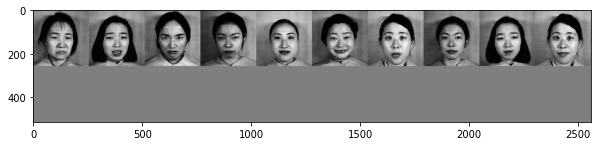

In [ ]:
x_ans = autoencoder.predict(x_test)
stack1 = np.concatenate(x_test, axis=1)
stack2 = np.concatenate(x_ans, axis=1)
stack2 = np.squeeze(stack2)
stack3 = np.concatenate([stack1, stack2], axis=0)
img = Image.fromarray(np.uint8(stack3 * 127.5 + 127.5))

plt.gray()
plt.figure(figsize=(10, 10))
img.save(img_f + str(epoch) + '.png')
plt.imshow(img, vmin = 0, vmax = 255)
plt.show()

In [ ]:
#学習
hist = autoencoder.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=2, callbacks=[EpisodeLogger()])

In [ ]:
from keras.models import load_model

#モデルを読み込み
model_encoder = load_model('/content/drive/MyDrive/sotsuron/AE_face2/h5_para/encoder_1000.h5')
model_encoder.summary() #モデル情報を出力

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      1568      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0

In [ ]:
tdata = '/content/drive/MyDrive/sotsuron/AE_face2/jaffedbase/jaffedbase/'
list_ = np.array(sorted(os.listdir(tdata)))
x_test = list(list_)
print(x_test)

['KA.AN2.40.tiff', 'KA.AN3.41.tiff', 'KA.DI1.42.tiff', 'KA.DI2.43.tiff', 'KA.DI3.44.tiff', 'KA.FE1.45.tiff', 'KA.FE2.46.tiff', 'KA.FE3.47.tiff', 'KA.FE4.48.tiff', 'KA.HA1.29.tiff', 'KA.HA2.30.tiff', 'KA.HA3.31.tiff', 'KA.HA4.32.tiff', 'KA.NE1.26.tiff', 'KA.NE2.27.tiff', 'KA.NE3.28.tiff', 'KA.SA1.33.tiff', 'KA.SA2.34.tiff', 'KA.SA3.35.tiff', 'KA.SU1.36.tiff', 'KA.SU2.37.tiff', 'KA.SU3.38.tiff', 'KL.AN1.167.tiff', 'KL.AN2.168.tiff', 'KL.AN3.169.tiff', 'KL.DI2.171.tiff', 'KL.DI3.172.tiff', 'KL.DI4.173.tiff', 'KL.FE1.174.tiff', 'KL.FE2.175.tiff', 'KL.FE3.176.tiff', 'KL.HA1.158.tiff', 'KL.HA2.159.tiff', 'KL.HA3.160.tiff', 'KL.NE1.155.tiff', 'KL.NE2.156.tiff', 'KL.NE3.157.tiff', 'KL.SA1.161.tiff', 'KL.SA2.162.tiff', 'KL.SA3.163.tiff', 'KL.SU1.164.tiff', 'KL.SU2.165.tiff', 'KL.SU3.166.tiff', 'KM.AN1.17.tiff', 'KM.AN2.18.tiff', 'KM.AN3.19.tiff', 'KM.DI1.20.tiff', 'KM.DI3.22.tiff', 'KM.FE2.24.tiff', 'KM.FE3.25.tiff', 'KM.HA1.4.tiff', 'KM.HA2.5.tiff', 'KM.HA3.6.tiff', 'KM.HA4.7.tiff', 'KM.NE1.1.

In [ ]:
tdata = '/content/drive/MyDrive/sotsuron/AE_music/test_myface/'
x_test = []
files = os.listdir(tdata)
for file in files:
    img = Image.open(tdata + file).convert('RGB'); img.close
    x_test.append(np.array(img))
x_test = np.array(x_test)
x_test = (x_test - 127.5) / 127.5

model_test = model_encoder.predict(x_test)

import numpy as np
np.set_printoptions(threshold=np.inf)
print(model_test)

7/7 [==============================] - 2s 263ms/step
[[ 1.         -1.          0.9999998  -1.          1.          1.
   1.          1.          1.         -1.          1.         -1.
   0.9999994  -1.         -1.         -1.         -0.99999845 -0.9999686
  -0.9999995  -0.99999917 -1.         -1.          1.          1.
  -1.         -1.         -0.99989706 -1.         -1.          1.
   1.         -0.9999986  -1.          1.          0.9999982  -1.
   1.         -1.          1.          1.         -1.         -0.9999995
   1.          1.          1.         -1.          1.         -1.
   1.         -0.9999988   1.          1.         -1.         -0.99999785
   1.          1.         -1.         -1.         -0.999994   -1.
  -0.99999684 -1.         -1.          1.          0.99999416  1.
   1.         -1.          1.         -0.9999984   0.9999995  -1.
   0.99999976  1.         -1.          1.         -1.          1.
   1.         -0.9999994   0.9999995  -1.          1.          0.99

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)
print(model_test[55])

[ 1.         -0.9999988   1.         -1.          1.          0.99999946
  1.          1.          1.         -1.          0.999997   -0.99999917
  0.99999785 -0.9999995  -1.         -0.9999997  -0.9999972  -0.99998665
 -0.99994814 -0.99999845 -0.9999997  -1.          1.          0.99964935
 -0.9999837  -0.99999976 -0.99996537 -1.         -0.9999984   1.
  1.         -0.9999986  -1.          1.          0.9999985   1.
  1.         -1.          1.          1.         -1.         -0.9999997
  0.9999995   1.          1.         -0.9999325   1.         -0.9999954
  0.99999946 -1.          1.         -1.         -1.         -0.99999905
  1.          0.9999995  -0.9999997  -1.         -0.9999756  -1.
 -1.         -0.9999985  -0.9999976   0.9999994   0.99999225  1.
  1.         -1.          1.         -1.          1.         -1.
  0.99999565  0.9999998  -1.          0.99999666 -1.          1.
  1.         -0.9999917   0.9999843  -0.9999713  -1.          0.9999975
 -0.99999803  1.          1. 